In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support as score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.isnull().sum() #To check is data contains any missing values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [3]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


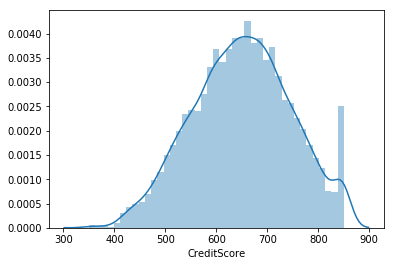

In [4]:
sns.distplot(df['CreditScore'])

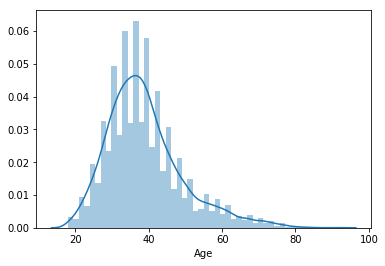

In [5]:
sns.distplot(df['Age'])

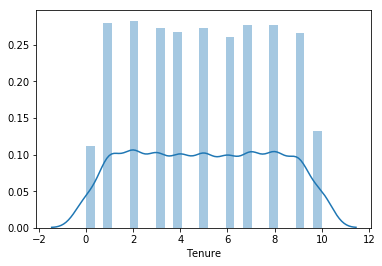

In [6]:
sns.distplot(df['Tenure'])

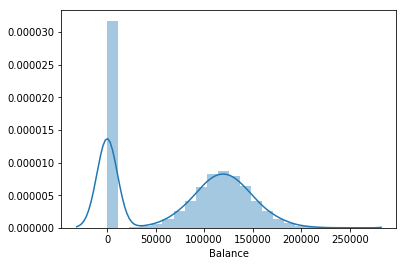

In [7]:
sns.distplot(df['Balance'])

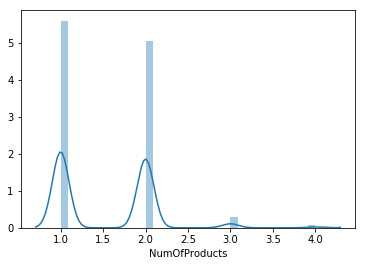

In [8]:
sns.distplot(df['NumOfProducts'])

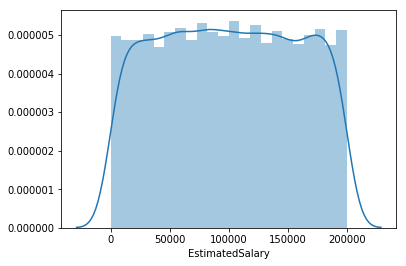

In [9]:
sns.distplot(df['EstimatedSalary'])

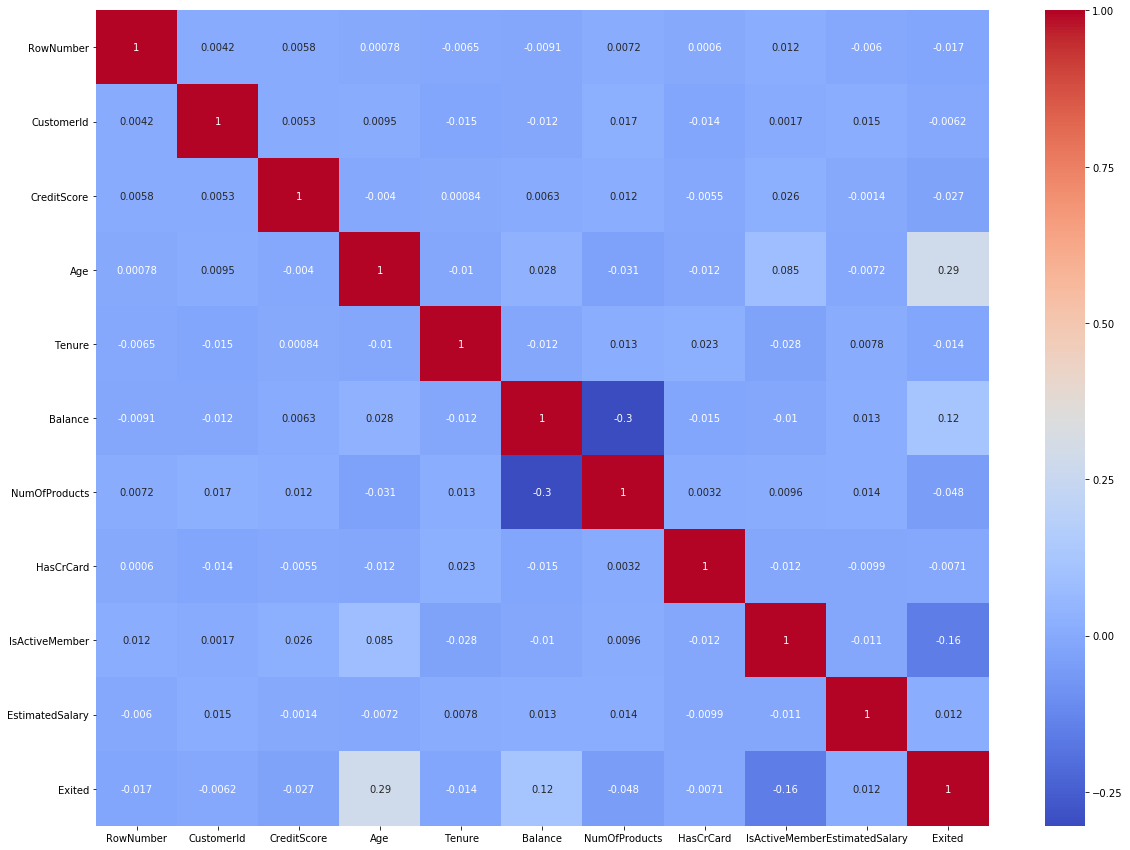

In [10]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)

In [11]:
#Converting Geography into matrix

lb = preprocessing.LabelBinarizer() #Calling the label binarizer function

lb.fit(df['Geography']) #Fitting it to the column for categorical data. 
geo_transformed = lb.transform(df['Geography']) #Applying the transform to the column
geo_lb = pd.DataFrame(data = geo_transformed, columns = lb.classes_) #Creating a new DF with transformed values

#Converting Gender to matrix

a = df.iloc[:,5]
b = np.where(a=='Male',1,0)
c = np.where(a=='Female',1,0)

m_df = pd.DataFrame(data = b, columns = ['Male'])
f_df = pd.DataFrame(data = c, columns = ['Female'])

gen_df = pd.concat([m_df,f_df], axis=1)
gen_df

,Male,Female
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,1,0
6,1,0
7,0,1
8,1,0
9,1,0


In [12]:
#Final DF

main_df = pd.concat([df, geo_lb, gen_df], axis =1)
y = df.iloc[:,13]
main_df.drop(labels=['Gender','Geography','RowNumber','CustomerId','Surname','Exited'],axis=1, inplace=True)

print(main_df.shape)
print(y.shape)

(10000, 13)
(10000,)


# PART 1: WORKING ON IMBALANCED DATASET

In [13]:
#Test-Train Split

x_train, x_test, y_train, y_test = train_test_split(main_df,y,test_size=0.2)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(8000, 13)
(8000,)
(2000,)
(2000, 13)


C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  import sys


# 1. SUPPORT VECTOR MACHINES (SVM)

1.1: SVM - LINEAR

In [14]:
svm = SVC(kernel = 'linear',random_state=0, C = 1.0, verbose=True)
svm.fit(x_train,y_train)

svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM][LibSVM]TRAIN_SCORE is: 0.795625
TEST_SCORE is: 0.799
precision:[0.799 0.   ], reccall:[1. 0.], accuracy:0.799, fscore[0.88827126 0.        ]


C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.2: SVM - RBF

In [15]:
svm = SVC(kernel = 'rbf',random_state=0, C = 5.0, verbose=True)
svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM]TRAIN_SCORE is: 0.88025
TEST_SCORE is: 0.8545
precision:[0.86900056 0.74235808], reccall:[0.96307885 0.42288557], accuracy:0.8545, fscore[0.91362422 0.53882726]


1.3: SVM -RBF (DIFFERENT PARAMETERS)

In [16]:
svm = SVC(kernel = 'rbf',random_state=0, C = 5.0, verbose=True, gamma='auto')
svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM]TRAIN_SCORE is: 0.88025
TEST_SCORE is: 0.8545
precision:[0.86900056 0.74235808], reccall:[0.96307885 0.42288557], accuracy:0.8545, fscore[0.91362422 0.53882726]


# 2. DECISION TREE CLASSIFIER

In [17]:
dt_model = tree.DecisionTreeClassifier()

print(dt_model)

dt_model.fit(x_train,y_train)

y_pred = dt_model.predict(x_test)

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
precision:[0.87197452 0.46744186], reccall:[0.85669587 0.5       ], accuracy:0.785, fscore[0.86426768 0.48317308]
[[1369  201]
 [ 229  201]]


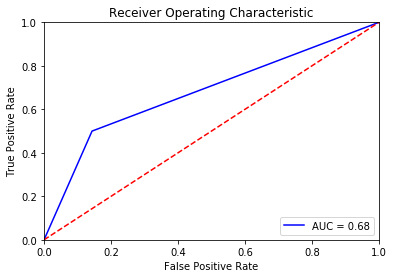

Area under the curve: 0.6783479349186483


In [18]:
# calculate the fpr and tpr for all thresholds of the classification
probs = dt_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    
print('Area under the curve:',roc_auc)

# 3. RANDOM FOREST CLASSIFIER

In [19]:
#RF

rf = RandomForestClassifier(n_estimators=400,max_depth=50)

rf_model = rf.fit(x_train,y_train)

print(rf_model)

y_pred = rf_model.predict(x_test)

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
precision:[0.87685291 0.75609756], reccall:[0.96245307 0.46268657], accuracy:0.862, fscore[0.9176611  0.57407407]
[[1538  216]
 [  60  186]]


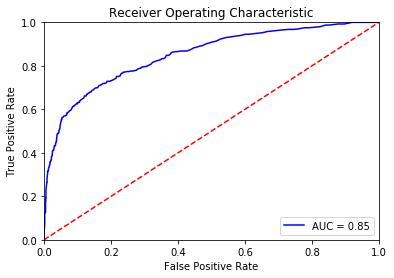

Area under the curve: 0.8494184272629344


In [20]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the curve:',roc_auc)

# 4. BOOSTING TECHNIQUES (XGB)

In [21]:
boost_model = XGBClassifier()
boost_model.fit(x_train, y_train)

print(boost_model)

y_pred = boost_model.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy: 86.70%
precision:[0.87840909 0.78333333], reccall:[0.96745932 0.46766169], accuracy:0.867, fscore[0.92078618 0.58566978]
[[1546  214]
 [  52  188]]


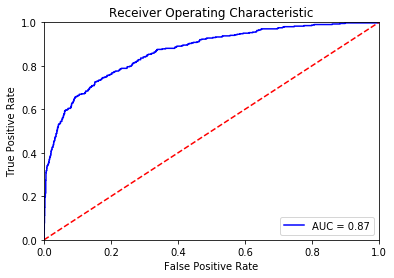

Area under the curve: 0.8671473670446267


In [22]:
# calculate the fpr and tpr for all thresholds of the classification
probs = boost_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the curve:',roc_auc)

# PART 2: UNDERSAMPLING MAJORITY DATA

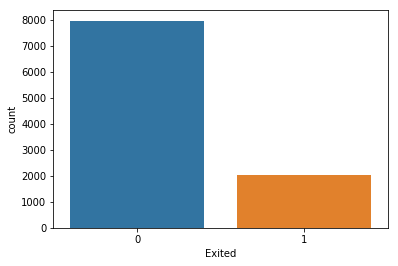

In [23]:
#This is happening becuase the dataset is imbalanced

#We will try both undersampling and oversampling.
#First is undersampling the Majority class i.e when the column 'Exited' has value  = 0

sns.countplot(df.Exited)

In [24]:
#UNDERSAMPLING MAJORITY i.e NOT EXITED

a = df[df.Exited == 1]
print(a.shape)

b = df[df.Exited == 0]
print(b.shape)

df_majority_downsampled = resample(b,replace=False,n_samples=2037,random_state=123)

df_downsampled = pd.concat([df_majority_downsampled,a])

df_downsampled.Exited.value_counts()

(2037, 14)
(7963, 14)


1    2037
0    2037
Name: Exited, dtype: int64

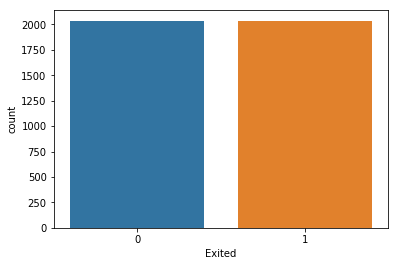

In [25]:
sns.countplot(df_downsampled.Exited)

In [26]:
df_downsampled

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1183,1184,15600992,Madukaego,652,France,Male,36,1,0.00,2,1,1,151314.98,0
4245,4246,15569446,Tu,732,France,Female,34,8,122338.43,2,1,0,187985.85,0
2164,2165,15794479,Becker,767,Spain,Male,77,8,149083.70,1,1,1,190146.83,0
6301,6302,15683183,Volkova,766,Germany,Female,45,6,97652.96,1,1,0,127332.33,0
4740,4741,15618661,Chidubem,535,France,Male,30,6,103804.97,1,1,1,125710.53,0
5441,5442,15602979,Lin,751,France,Male,29,1,135536.50,1,1,0,66825.33,0
9623,9624,15796790,Amaechi,573,France,Female,47,8,154543.98,1,1,0,29586.73,0
561,562,15800440,Power,650,Spain,Male,61,1,152968.73,1,0,1,82970.69,0
1229,1230,15607598,Muravyov,575,Spain,Female,31,6,0.00,2,1,1,95686.42,0
6127,6128,15708693,Sherman,759,France,Female,33,2,0.00,2,1,0,56583.88,0


In [27]:
onehotencoder=OneHotEncoder()
le = preprocessing.LabelEncoder()

#Converting Geography into matrix

df_downsampled['Geography'] = le.fit_transform(df_downsampled['Geography'])
var2 = onehotencoder.fit_transform(df_downsampled[['Geography']])

df_downsampled['Spain'] = np.where(var2.A[:,0] ==1,1,0)
df_downsampled['Germany'] = np.where(var2.A[:,1] ==1,1,0)
df_downsampled['France'] = np.where(var2.A[:,2] ==1,1,0)

#Converting Gender into matrix
df_downsampled['Gender']=le.fit_transform(df_downsampled['Gender'])

var1 = onehotencoder.fit_transform(df_downsampled[['Gender']])

print(type(var1.A))

print(len(var1.A[:,1]))

df_downsampled['Female'] = np.where(var1.A[:,0] ==0,0,1)
df_downsampled['Male'] = np.where(var1.A[:,1] ==1,1,0)

<class 'numpy.ndarray'>
4074


C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, y

In [28]:
new_df = df_downsampled.copy()

y = new_df.iloc[:,13]
y
print(y.shape)

new_df.drop(labels=['Gender','Geography','RowNumber','CustomerId','Surname','Exited'],axis=1, inplace=True)
print(new_df.shape)

(4074,)
(4074, 13)


In [29]:
new_df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Spain,Germany,France,Female,Male
1183,652,36,1,0.00,2,1,1,151314.98,1,0,0,0,1
4245,732,34,8,122338.43,2,1,0,187985.85,1,0,0,1,0
2164,767,77,8,149083.70,1,1,1,190146.83,0,0,1,0,1
6301,766,45,6,97652.96,1,1,0,127332.33,0,1,0,1,0
4740,535,30,6,103804.97,1,1,1,125710.53,1,0,0,0,1
5441,751,29,1,135536.50,1,1,0,66825.33,1,0,0,0,1
9623,573,47,8,154543.98,1,1,0,29586.73,1,0,0,1,0
561,650,61,1,152968.73,1,0,1,82970.69,0,0,1,0,1
1229,575,31,6,0.00,2,1,1,95686.42,0,0,1,1,0
6127,759,33,2,0.00,2,1,0,56583.88,1,0,0,1,0


In [30]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size = 0.2, random_state = 0)

# Feature Scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3259, 13)
(3259,)
(815, 13)
(815,)


C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\rpatil\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  import sys


# PART 1: SVM

In [31]:
svm = SVC(kernel = 'linear',random_state=0, C = 1.0, verbose=True)
svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, recall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM]TRAIN_SCORE is: 0.7146363915311446
TEST_SCORE is: 0.7153374233128834
precision:[0.71990172 0.71078431], recall:[0.71289538 0.71782178], accuracy:0.7153374233128834, fscore[0.71638142 0.71428571]


In [32]:
svm = SVC(kernel = 'rbf',random_state=0, C = 5.0, verbose=True)
svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, recall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM]TRAIN_SCORE is: 0.8293955200981896
TEST_SCORE is: 0.7730061349693251
precision:[0.76525822 0.781491  ], recall:[0.79318735 0.75247525], accuracy:0.7730061349693251, fscore[0.77897252 0.7667087 ]


In [33]:
svm = SVC(kernel = 'rbf',random_state=0, C = 5.0, verbose=True, gamma='auto')
svm_model = svm.fit(x_train,y_train)

y_pred = svm_model.predict(x_test)

print('TRAIN_SCORE is:',svm.score(x_train,y_train))
print('TEST_SCORE is:',svm.score(x_test, y_test))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, recall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

[LibSVM]TRAIN_SCORE is: 0.8293955200981896
TEST_SCORE is: 0.7730061349693251
precision:[0.76525822 0.781491  ], recall:[0.79318735 0.75247525], accuracy:0.7730061349693251, fscore[0.77897252 0.7667087 ]


# PART 2: DECISION TREES

In [34]:
dt_model = tree.DecisionTreeClassifier()

print(dt_model)

dt_model.fit(x_train,y_train)

y_pred = dt_model.predict(x_test)

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
precision:[0.70289855 0.70074813], reccall:[0.7080292  0.69554455], accuracy:0.701840490797546, fscore[0.70545455 0.69813665]
[[291 123]
 [120 281]]


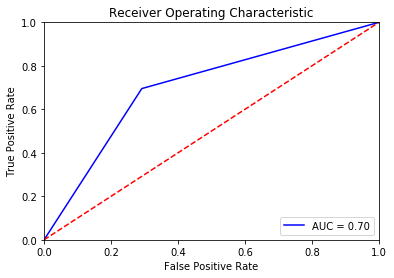

Area under the curve: 0.7017868757678687


In [35]:
# calculate the fpr and tpr for all thresholds of the classification
probs = dt_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the curve:',roc_auc)

# PART 3: RANDOM FOREST CLASSIFIER

In [36]:
#RF

rf = RandomForestClassifier(n_estimators=400,max_depth=50)

rf_model = rf.fit(x_train,y_train)

print(rf_model)

y_pred = rf_model.predict(x_test)

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
precision:[0.75700935 0.7751938 ], reccall:[0.78832117 0.74257426], accuracy:0.7656441717791411, fscore[0.77234803 0.7585335 ]
[[324 104]
 [ 87 300]]


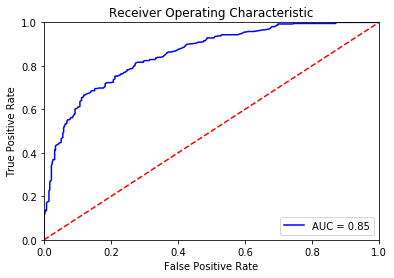

Area under the curve: 0.8541019247910192


In [37]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the curve:',roc_auc)

# PART 4: GRADIENT BOOSTING TECHNIQUES (XGB)

In [38]:
xgb_model = XGBClassifier(n_estimators=25)
xgb_model.fit(x_train, y_train)

print(xgb_model)

y_pred = xgb_model.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision, recall, fscore, support= score(y_test,y_pred)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred),fscore))

cm = confusion_matrix(y_pred, y_test)
print(cm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=25,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy: 78.53%
precision:[0.76457399 0.8102981 ], reccall:[0.8296837  0.74009901], accuracy:0.7852760736196319, fscore[0.7957993  0.77360931]
[[341 105]
 [ 70 299]]


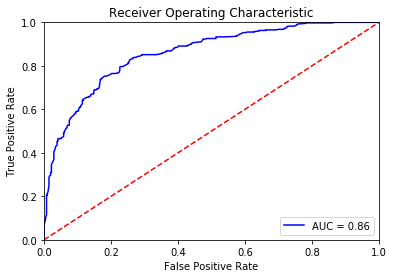

Area under the curve: 0.8579111560791116


In [39]:
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Area under the curve:',roc_auc)